# Generator Model

In [24]:
import torch
from NewsroomHelper import get_newsroom_datasets
from models import Summarizer
from model_helpers import loss_function, error_function
from utils import produce_attention_visualization_file, summarize, get_text_triplets, produce_summary_files, run_rouge
from pytorch_helper import VariableBatchDataLoader, ModelManipulator, plot_learning_curves

## Parameters

In [13]:
# training parameters
BATCH_SIZE = 64
NUM_EPOCHS = 1
LEARNING_RATE = 1e-2
# INITIAL_ACCUMULATOR_VALUE = 0.1
GAMMA = 1
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
BEAM_SIZE = 4

True


## Get Data

In [14]:
# pico_dataset_train, pico_dataset_dev, pico_dataset_test = get_pico_datasets()
newsroom_dataset_train, newsroom_dataset_dev, newsroom_dataset_test, preprocessor = get_newsroom_datasets()
word_vectors = preprocessor.word_vectors
start_index = preprocessor.word_indices['<start>']
end_index = preprocessor.word_indices['<end>']

11029 3676 3678
retrieving word2vec model from file


## Create Model

In [15]:
generator_model = Summarizer(preprocessor, start_index, end_index, num_hidden1=None, num_hidden2=None)

## Train and Save Model

In [16]:
dataloader = VariableBatchDataLoader(newsroom_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(generator_model.parameters(),
                             lr=LEARNING_RATE)
# optimizer = torch.optim.Adagrad((generator_model.cuda() if USE_CUDA else generator_model).parameters(),
#                                 lr=LEARNING_RATE, initial_accumulator_value=INITIAL_ACCUMULATOR_VALUE)
model_manip = ModelManipulator(generator_model, optimizer, loss_function, error_function, use_cuda=USE_CUDA)
train_stats, val_stats = model_manip.train(dataloader, NUM_EPOCHS, dataset_val=newsroom_dataset_dev, stats_every=10, verbose_every=10)

epoch: 0, batch: 0, train_loss: 707.275513, train_error: None
epoch: 0, batch: 10, train_loss: 515.430054, train_error: None
epoch: 0, batch: 20, train_loss: 470.217834, train_error: None
epoch: 0, batch: 30, train_loss: 454.169495, train_error: None
epoch: 0, batch: 40, train_loss: 443.429871, train_error: None
epoch: 0, batch: 50, train_loss: 443.787781, train_error: None
epoch: 0, batch: 60, train_loss: 422.315582, train_error: None
epoch: 0, batch: 70, train_loss: 429.262482, train_error: None
epoch: 0, batch: 80, train_loss: 429.967377, train_error: None
epoch: 0, batch: 90, train_loss: 413.983093, train_error: None
epoch: 0, batch: 100, train_loss: 414.386414, train_error: None
epoch: 0, batch: 110, train_loss: 407.835602, train_error: None
epoch: 0, batch: 120, train_loss: 412.452728, train_error: None
epoch: 0, batch: 130, train_loss: 394.479797, train_error: None
epoch: 0, batch: 140, train_loss: 411.401672, train_error: None
epoch: 0, batch: 150, train_loss: 396.672668, train

In [17]:
torch.save(generator_model, 'models/generator_temp.model')

In [18]:
generator_model = torch.load('models/generator_temp.model')

## Plot

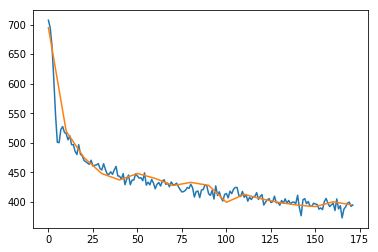

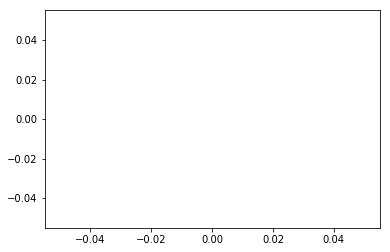

In [19]:
plot_learning_curves(training_values=train_stats, validation_values=val_stats, figure_name='graphs/generator_training_temp')

In [20]:
batch = newsroom_dataset_dev[0:5]
results = summarize(batch, generator_model, beam_size=BEAM_SIZE)

/home/jered/Documents/Projects/Summarization/submodules.py:23: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  output, (h, c) = self.lstm(x)


In [21]:
summary_info = results[0]
triplets = get_text_triplets(batch, summary_info, preprocessor)
for i,(text, reference_summary, decoded_summary) in enumerate(triplets):
    loss = summary_info[2][i]
    print("text", text)
    print("reference summary", reference_summary)
    print("decoded summary", decoded_summary)
    print(loss)

text ['<start>', 'ray', 'watson', 'visits', 'bobbi', 'kristina', 'brown', "'s", 'atlanta', 'hospice', 'qqq', 'at', 'qqq', 'pm', 'edt', 'family', 'and', 'loved', 'ones', 'continue', 'to', 'flock', 'to', "'s", 'bedside', 'at', 'an', 'atlanta', '-', 'area', 'hospice', 'as', 'her', 'condition', 'deteriorates', '.', 'ray', 'watson', ',', 'the', 'former', 'bodyguard', 'of', 'bobbi', 'kristina', "'s", 'and', 'the', 'brother', 'of', 'the', 'qqq', '-', 'old', "'s", 'aunt', 'pat', 'houston', ',', 'was', 'spotted', 'arriving', 'at', 'the', 'hospice', 'on', 'thursday', '.', 'watson', ',', 'who', 'was', 'working', 'as', 'houston', "'s", 'bodyguard', 'when', 'she', 'at', 'the', 'beverly', 'hilton', ',', 'also', 'at', 'her', 'newark', ',', 'new', 'jersey', 'in', 'february', 'of', 'that', 'year', '.', 'bobbi', 'kristina', 'was', 'moved', 'to', 'hospice', 'care', 'last', 'week', 'as', 'she', 'has', 'remained', 'unresponsive', 'in', 'the', 'months', 'following', 'the', 'to', 'chicago', 'prior', 'to', 't

In [22]:
summary_info = results[0]
i = 0

triplets = get_text_triplets(batch, summary_info, preprocessor)

text, decoded_summary, reference_summary = triplets[i]
attentions, p_gens = [[float(f) for f in vector[1:-1]] for vector in summary_info[4][i][:-1]], [float(0) for j in range(len(decoded_summary)-1)]

produce_attention_visualization_file('graphs/attn_vis_data.json', text, decoded_summary, " ".join(reference_summary), attentions, p_gens)

In [25]:
dataloader = VariableBatchDataLoader(newsroom_dataset_dev, batch_size=5, shuffle=True)
produce_summary_files(dataloader, generator_model, "rouge", beam_size=BEAM_SIZE, max_num_batch=10)

0
1
2
3
4
5
6
7
8
9


In [27]:
run_rouge()

2.3449 0.50367 3.29304
